In [67]:
import sys
import os

import librosa  # python package for music and audio analysis
import librosa.display
import torchaudio
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import noisereduce as no
import matplotlib.image as mpimg

import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head(10)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
5,4.0,no,aldfly,2 (stereo),2013-05-27,Not specified,7,XC135459.mp3,Not specified,Alder Flycatcher,...,135459,https://www.xeno-canto.org/135459,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,Not specified,08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
6,4.0,no,aldfly,2 (stereo),2013-05-27,Not specified,45,XC135460.mp3,Not specified,Alder Flycatcher,...,135460,https://www.xeno-canto.org/135460,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,Not specified,10:00,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
7,3.5,no,aldfly,2 (stereo),2013-05-30,increasing,71,XC135883.mp3,level,Alder Flycatcher,...,135883,https://www.xeno-canto.org/135883,United States,Guy McGrane,Empidonax alnorum_Alder Flycatcher,-81.4814,0-3(s),10:30,Guy McGrane,Creative Commons Attribution-NonCommercial-Sha...
8,4.0,no,aldfly,2 (stereo),2013-06-02,both,26,XC137570.mp3,accelerating,Alder Flycatcher,...,137570,https://www.xeno-canto.org/137570,Canada,Martin St-Michel,Empidonax alnorum_Alder Flycatcher,-70.42,0-3(s),07:03,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...
9,3.5,no,aldfly,1 (mono),2013-06-16,Not specified,54,XC138639.mp3,Not specified,Alder Flycatcher,...,138639,https://www.xeno-canto.org/138639,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-91.4698,Not specified,06:24,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0


In [61]:
def load_audio_fast(file_path):
    sample_rate = 22050
    signal, original_sr = torchaudio.load(file_path, normalization=False)
    signal = torchaudio.transforms.Resample(original_sr, sample_rate)(signal)
    signal = torch.mean(signal, dim=0, keepdim=True)
    signal = signal.cpu().numpy().squeeze()
        
    return (signal, sample_rate)

In [62]:
fmin = 300
# References:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# https://github.com/m-kortas/Sound-based-bird-species-detection/blob/master/MK_prepareData.ipynb
def get_melspectrogram_db(file_path):
    n_fft = 2048
    hop_length = 512   
    n_mels = 256

    signal, sr = load_audio_fast(file_path)
    
    signal = no.reduce_noise(audio_clip=signal, noise_clip=signal, verbose=False)

    spec = librosa.feature.melspectrogram(
        signal, 
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin
    )
    
    return (librosa.power_to_db(spec, ref=np.max), sr)

In [63]:
# References:
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    spec_scaled = np.flip(spec_scaled, axis=0)

    return spec_scaled

In [64]:
def file_to_imgs(file, bird_storage_dir, existing_file_labels):
    if file.endswith(".mp3"):
        file_label = file.split('/')[-1].split('.')[0]

        if file_label in existing_file_labels[bird]:
            return

        img = spec_to_image(get_melspectrogram_db(file))
        split_num = int(np.ceil(img.shape[1]/64800)) # about 25 mins 
        imgs = np.array_split(img, split_num, axis=1)
        
        for i, img in enumerate(imgs):
            mpimg.imsave(bird_storage_dir + "/" + file_label + '-' + str(i + 1)  + '.jpeg', img, cmap='gray')

In [65]:
# Example
train.iloc[7]

rating                                                            3.5
playback_used                                                      no
ebird_code                                                     aldfly
channels                                                   2 (stereo)
date                                                       2013-05-30
pitch                                                      increasing
duration                                                           71
filename                                                 XC135883.mp3
speed                                                           level
species                                              Alder Flycatcher
number_of_notes                                                   1-3
title                   XC135883 Alder Flycatcher (Empidonax alnorum)
secondary_labels    ['Geothlypis trichas_Common Yellowthroat', 'Du...
bird_seen                                                         yes
sci_name            

In [41]:
example_file = './data/train_audio/aldfly/XC135883.mp3'

In [42]:
mel, sr = get_melspectrogram_db(example_file)
img = spec_to_image(mel)

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [43]:
mel.shape

(256, 3068)

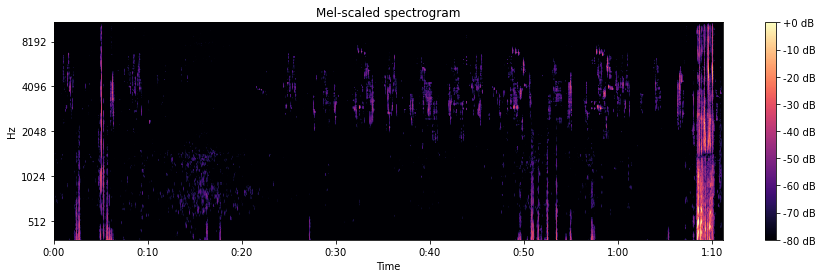

In [44]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel, fmin=fmin, y_axis='mel', x_axis='time', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

In [68]:
mel, sr = get_melspectrogram_db(example_file)
img = spec_to_image(mel)

In [69]:
mel.shape

(256, 3068)

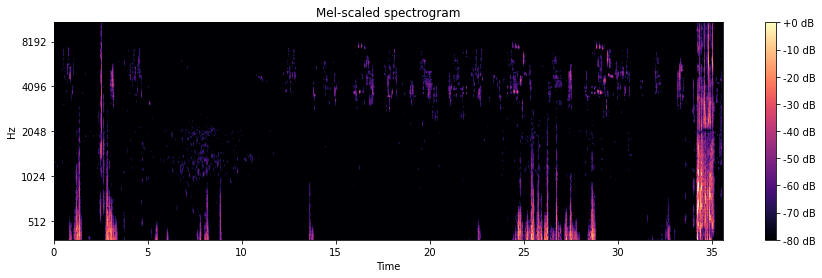

In [70]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel, fmin=fmin, y_axis='mel', x_axis='time', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

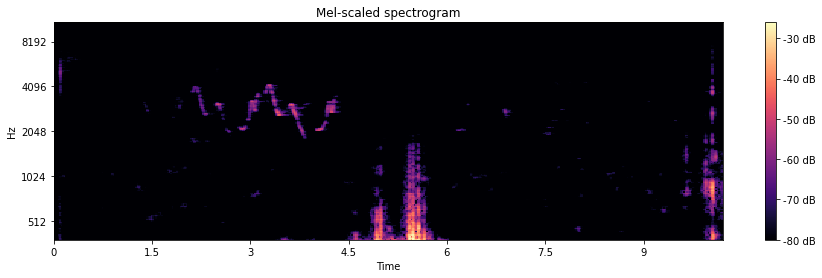

In [20]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel[:, :440], fmin=fmin, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

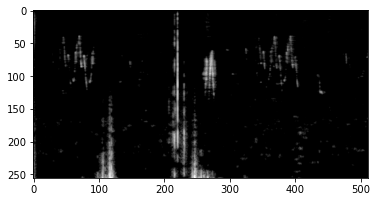

In [17]:
plt.imshow(img[:, :512], cmap='gray')

In [18]:
mpimg.imsave("example.jpeg", img, cmap='gray')

In [5]:
working_dir = "./data/train_audio/"
birds = []
flist = {} 

for root, dirs, files in os.walk(working_dir):
    if root == working_dir:
        birds = dirs

for i, bird in enumerate(birds):
    blist = [] 
    
    for root, dirs, files in os.walk(working_dir + bird):
        for file in files:
            if file.endswith(".mp3"):
                blist.append(os.path.join(root, file))

    flist[bird] = blist

In [6]:
storage_dir = "./data/train_img/"
existing_file_labels = {}

for i, bird in enumerate(birds):
    blist = [] 
    
    for root, dirs, files in os.walk(storage_dir + bird):
        for file in files:
            if file.endswith(".jpeg"):
                blist.append(file.split('-')[0].split('.')[0])

    existing_file_labels[bird] = blist

In [7]:
num_cores = multiprocessing.cpu_count()

In [8]:
len(birds)

257

In [9]:
import warnings
warnings.filterwarnings('ignore')

birds_handled = 0

for bird, files in flist.items():
    bird_dir = storage_dir + bird
    
    if not os.path.exists(bird_dir):
        os.mkdir(bird_dir)
    
    birds_handled += 1
    print(birds_handled)

    Parallel(n_jobs=num_cores - 2)(
        delayed(file_to_imgs)(file, storage_dir + bird, existing_file_labels) for file in files
    )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
